# Preprocessing for the new CSV file
This file contains some preprocessing steps

## Load the data

In [1]:
import pandas as pd

# We don't have header row and we have to specifiy a column seperator
news_articles = pd.read_csv("../dataset/training_data_lowercase.csv", header=None, sep="	", names=["label", "text"])

print(news_articles.dtypes, news_articles.shape)
news_articles.head()

label     int64
text     object
dtype: object (34152, 2)


,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


## Deeper data evaluation

In [2]:
# check for missing values
print(news_articles.isnull().sum())

# Understand the data
print("Unique label values:", news_articles.label.unique())

# Check for empty strings
empty_text = news_articles[news_articles.text.str.strip() == '']

print(f"Empty texts: {len(empty_text)}")

# Check for duplicated articles
print("Duplicated entries:", news_articles.duplicated(subset=["text"]).sum())

label    0
text     0
dtype: int64
Unique label values: [0 1]
Empty texts: 0
Duplicated entries: 1946


## Data cleaning
### Basic data cleaning

In [3]:
# Remove duplicates and keep the first one
news_articles = news_articles.drop_duplicates(subset=["text"])

news_articles.shape

(32206, 2)

## Train / Test Split
Perform train / test split before text preprocessing to avoid data leakage.<br />
This ensures that no information from the test set influences the preprocessing steps.

In [4]:
from sklearn.model_selection import train_test_split

y = news_articles.label
X = news_articles.text

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0, shuffle=True)

## Preprocess text column

In [26]:
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()

def text_preprocessing_pipeline(text):
    """
    Preprocesses a text string by applying standard NLP cleaning steps:
    tokenization, stop word removal, punctuation removal, and lemmatization.

    Parameters:
        text (str): The input text string to preprocess.

    Returns:
        str: A cleaned and lemmatized string with tokens joined by spaces.
    """
    # Tokenize the text
    tokenized_text = word_tokenize(text.lower())

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [w for w in tokenized_text if w.lower() not in stop_words]

    # Remove punctuation
    filtered_tokens = [w for w in filtered_tokens if w not in string.punctuation]

    # Apply lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in filtered_tokens]

    return " ".join(lemmatized_tokens)

X_train = X_train.apply(text_preprocessing_pipeline)

## Visualization

label
1    16181
0    16025
Name: count, dtype: int64


/var/folders/zf/m3g54d9d25q0jn4s7wbccll00000gn/T/ipykernel_99028/1283245949.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=news_articles, palette={"0": "#CAF53F", "1": "#0CC685"})


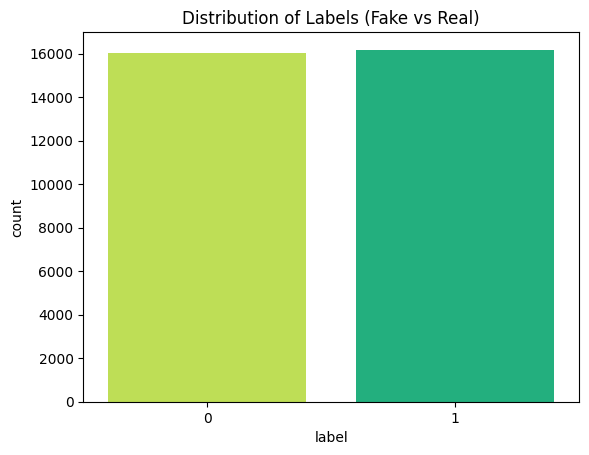

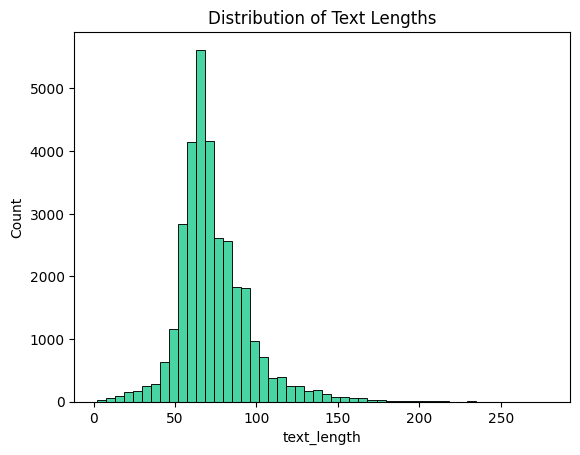

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of the target variable (label)
print(news_articles.label.value_counts())
sns.countplot(x="label", data=news_articles, palette={"0": "#CAF53F", "1": "#0CC685"})
plt.title('Distribution of Labels (Fake vs Real)')
plt.show()

# Add a new column 'text_length'
news_articles['text_length'] = news_articles.text.apply(lambda x: len(x))

# Length of the texts (tokens)
sns.histplot(news_articles['text_length'], bins=50, color="#0CC685")
plt.title('Distribution of Text Lengths')
plt.show()

# Remove column, it is not needed anymore
news_articles.drop(columns=["text_length"], inplace=True)